# Ben Forleo

### Text mining project

#### Background and research question

On January 7, 2017 the Office of the Director of National Intelligence released a declassified report detailing a Russian campaign to influence the 2016 election.  The report described a broad range of activities aimed at denigrating Secretary Hillary Clinton and undermining faith in the US democratic process. One facet of this campaign involved social media “trolls” employed by the Internet Research Agency, an organization financed by a close Putin ally with ties to Russian intelligence.  In an indictment of the Internet Research Agency dated February 16, 2018, special counsel Robert Mueller III accused this organization of attempting to sow discord online by posting derogatory and false information with an intent to interfere in the US 2016 election.

On August 27, 2018, the data journalism organization FiveThirtyEight published 2,973,371 tweets from accounts identified by Twitter as being associated with the Internet Research Agency. The dataset is the product of work done by Clemson Univeristy Professors Darren Linville and Patrick Warren who collected the data from Clemson University's Social Media Listening center. The researchers also classifed accounts according to their language and behavior: categories include Right Troll, Left Troll, News Feed, Hashtag Gamer, and Fearmonger. 

In a [working paper](http://pwarren.people.clemson.edu/Linvill_Warren_TrollFactory.pdf) describing their work, Linville and Warren discuss their procedure for labeling accounts, which essentially was an extensive qaulitative analysis.

The purpose of this project is to test whether the account categorization scheme can be replicated quanitatively using unsupervised learning teqniques. 


#### Procedure

The procedure that I will employ is as follows:

- Clean and tokenize text using the spaCy library
- Create vectorized representations of tweets using the doc2vec algorithm that is available in the Gensim libbrary
- Cluster the vector representation of tweets using Gaussian mixture models. 
- Assign an account to a particular cluster based on how tweets were clustered. If a majority of an accounts tweets appeared in cluster A, label that account as being part of cluster A. 
- Compare the results of this algorithmic labeling scheme with the labels assigned by Linville and Warren

Let's import some data!

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

import spacy
import os
import pickle

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from unidecode import unidecode

# import plotly.offline as pyo
# import plotly.graph_objs as go


df = pd.read_pickle('/Users/benjaminforleo/disinformation_project_data/labeled_tweets.pkl')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

As always, we need to perform some EDA to get a sense of what's in our datset. 

In [3]:
# I only care about english only tweets (can't speak Russian, unfortunatly)
df = df[df.language == "English"]

print("Shape: ", df.shape, "\n", "\n"
     "# Unique accounts: ", len(set(df.author)), "\n", "\n",
     "Account Type: ", list(set(df.account_type)), "\n", "\n",
     "Account Category: ", list(set(df.account_category)))

Shape:  (2116867, 21) 
 
# Unique accounts:  2161 
 
 Account Type:  ['Spanish', 'German', 'Koch', 'news', 'Portuguese', '?', 'French', 'Right', 'Commercial', 'Italian', 'Hashtager', 'Left', 'ZAPOROSHIA', 'Russian', 'Ebola ', 'local', 'Arabic'] 
 
 Account Category:  ['LeftTroll', 'NewsFeed', 'HashtagGamer', 'Unknown', 'Commercial', 'NonEnglish', 'Fearmonger', 'RightTroll']


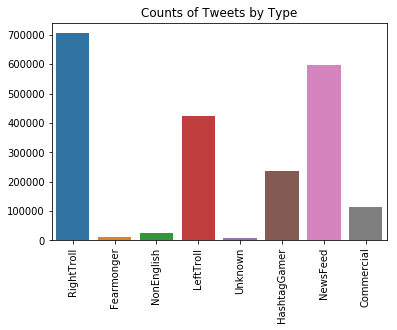

In [4]:
counts_by_type = dict(Counter(df.account_category))

account_type = list(counts_by_type.keys())
values = list(counts_by_type.values())

plt.clf()
sns.barplot(account_type, values)
plt.xticks(rotation = 'vertical')
plt.title('Counts of Tweets by Type')
plt.show()

# data = [go.Bar(x = account_type, y = values)]
# layout = go.Layout(title = "Counts of Tweets by Category")
# fig = go.Figure(data = data, layout = layout)
# pyo.plot(fig)

This is interesting. Let's see how this stacks up per account.

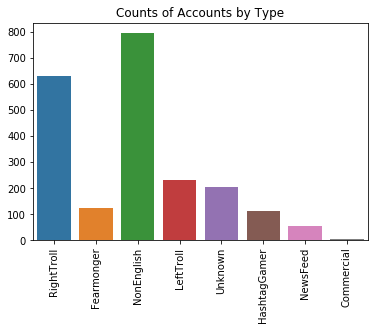

In [5]:
account_analysis = df.groupby(['author', 'account_category'])['content'].count().reset_index()

account_analysis = Counter(account_analysis.account_category)

account_type = list(account_analysis.keys())
values = list(account_analysis.values())

plt.clf()
sns.barplot(account_type, values)
plt.xticks(rotation = 'vertical')
plt.title('Counts of Accounts by Type')
plt.show()

Ok, this may be a bit confusing. A NonEnglish account may still tweet in English but the content is generally about international subjects, such as the war in Ukraine. 

We need to do some more filtering. 

In [6]:
# Let's get counts of the number of tweets by each author
counts_by_author = df[['author', 'content']].groupby('author').count()

counts_by_author.reset_index(inplace = True)

print(sum(counts_by_author.content > 400))

author_series = counts_by_author.author[counts_by_author.content > 400]

df = df[df.author.isin(author_series)]

463


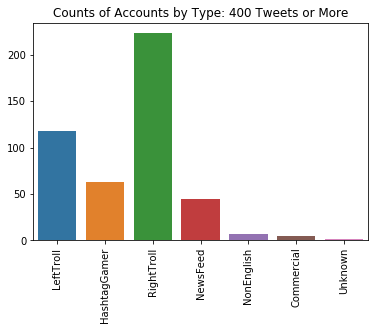

In [7]:
account_analysis = df.groupby(['author', 'account_category'])['content'].count().reset_index()

account_analysis = Counter(account_analysis.account_category)

account_type = list(account_analysis.keys())
values = list(account_analysis.values())

plt.clf()
sns.barplot(account_type, values)
plt.xticks(rotation = 'vertical')
plt.title('Counts of Accounts by Type: 400 Tweets or More')
plt.show()

In order to give my proposed procedure a chance to work, I need to make sure that I have enough tweets per account. Let's filter to accounts that have tweeted 300 or more times. The choice of 300 here is arbitrary. 

# Sampling and Pre-Processing

In [8]:
df.content = df.content.astype(str)

# Create the groupby object of author and category. Note: every author is assigned one category
df_sampled = df.groupby(['author', 'account_category'])['content']

# Take a 30% sample from each group
df_sampled = df_sampled.apply(lambda x: x.sample(frac=0.3, replace = False)).reset_index()

Basic pre-processing: remove RT symbol and hyperlinks

In [9]:
# SAMPLE AND PRE-CLEANING

# REMOVE RT SYMBOL
#from processing_functions import rt_remover
#df_sampled.content = df_sampled.content.apply(rt_remover)

# REMOVE ANY HYPERLINKS
from processing_functions import link_remover
df_sampled.content = df_sampled.content.apply(link_remover)


# STRIP ANY WHITESPACE ON EITHER SIDE OF THE TEXT
df_sampled.content = df_sampled.content.str.strip()

Now that we have done some basic pre-processing, we can parse our text with spaCy

### spaCy

In [10]:
from spacy.tokens import Token
Token.set_extension('is_hashtag', default = False, force = True)
Token.set_extension('is_account', default = False, force = True)

##### import functions, preprocess and tokenize the text

from processing_functions import hashtag_pipe
from processing_functions import is_account_pipe

# to disable pipeline objects: disable = ['parser', 'etc']
nlp = spacy.load("en", disable = ['parser', 'ner'])
nlp.add_pipe(hashtag_pipe)
nlp.add_pipe(is_account_pipe)

parsed_tweets = list(nlp.pipe(df_sampled.content))

# Gensim


- I need to do some more cleaning and processing before runing through gensim

In [11]:
from processing_functions import clean_doc
lemma = list(map(clean_doc, parsed_tweets))

# from processing_functions import clean_doc_no_lemma
# no_lemma = list(map(clean_doc_no_lemma, parsed_tweets))

#### Group tweets by author

In [12]:
# each row in parsed content is a list of lists
df_sampled['parsed_content'] = lemma

# lets flatten those so that each row only has one list
from processing_functions import group_lists
        
df_grouped = df_sampled.groupby(['author', 
                    'account_category'])['parsed_content'].apply(group_lists).reset_index()

# Convert the parsed content Series to a list for gensim
parsed_content = list(df_grouped.parsed_content)


#### create the gensim doc2vec model

In [13]:
# create a doc2vec model
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# lemma is the list of text
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(parsed_content)]

model = Doc2Vec(documents, vector_size=300, window=5, min_count=3, workers=6)

In [14]:
arr_list = []

for index in range(0, len(model.docvecs)):
    arr_list.append(model.docvecs[index])
    
    
test_array= np.stack(arr_list)

test_array = np.stack(arr_list)

In [15]:
from sklearn.manifold import TSNE
tsne_35 = TSNE(n_components = 2, perplexity = 35, verbose = 0 , n_iter = 1000).fit_transform(test_array)

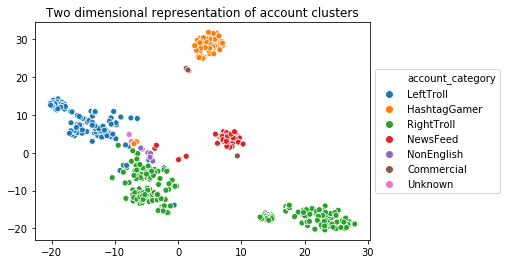

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()

sns.scatterplot(x = tsne_35[:,0], y = tsne_35[:, 1], hue = df_grouped.account_category)
plt.title("Two dimensional representation of account clusters")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# dope. lets see how kmeans works

In [ ]:
from sklearn.cluster import KMeans

inertias = []
clusters = list(range(1,11))

for k in clusters:
    
    model = KMeans(n_clusters = k)
    
    model.fit(test_array)
    
    inertias.append(model.inertia_)

In [ ]:
plt.plot(clusters, inertias)
plt.show()

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)

predicted = kmeans.fit_predict(test_array)

In [ ]:
# categories = pd.Series(predicted).astype(str)

In [ ]:
# def troll_labeler(cat):
#     if cat == 0:
#         return 'HashtagGamer'
    
#     elif cat == 1:
#         return 'RightTroll_1'
    
#     elif cat == 3:
        
#         return 'RightTroll_2'
    
#     else:
        
#         return "LeftTroll"

In [ ]:
cat= pd.Series(predicted).apply(troll_labeler)

In [ ]:
plt.clf()
plt.figure(figsize=(10,7))
sns.scatterplot(tsne_35[:,0], y = tsne_35[:, 1], hue = predicted)
plt.title('2D representation of doc2vec clusters using Kmeans')


plt.show()

In [ ]:
import plotly.offline as pyo
import plotly.graph_objs as go

data = [go.Scatter(x = tsne_35[:,0], y =  tsne_35[:, 1], mode = 'markers')]

pyo.plot(data)

In [ ]:
# non-negative matrix factorization

In [ ]:
# from sklearn.cluster import KMeans

# inertias = []
# clusters = list(range(1,11))

# for k in clusters:
    
#     model = KMeans(n_clusters = k)
    
#     model.fit(test_array)
    
#     inertias.append(model.inertia_)

In [ ]:
# import matplotlib.pyplot as plt

# plt.plot(clusters, inertias)
# plt.show()

In [ ]:
#df_grouped = df_grouped.groupby(['author', 'account_category'])['parsed_content'].agg(lambda col: ' '.join(col)).reset_index()


In [ ]:
your_df.groupby(['account_id'])['text_column'].agg(lambda col: ' '.join(col)).reset_index()


In [ ]:
your_df.groupby(['account_id'])[['text_column', 'score_column']].agg('text_column':lambda col: ' '.join(col),
                                                                    'score_column':'mean')